# *BLOCK 1. Import useful libraries*

In [1]:
# Libraries for data management
import pandas as pd
import numpy as np
import xarray as xr

# Libraries for modeling and optimization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Libraries for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Other libraries
from datetime import datetime, timedelta
import collections

# *BLOCK 2. Open and read the data file*

!REMEMBER TO UPLOAD THE FILE!
It's a matrix with 30 modes of EOFs of monthly temperatures from January 1940 to december 2022 (83 years). (Matrix [n. EOF, time]).

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/dati/save_eof.nc'

Mounted at /content/drive


In [3]:
# Read file
data = xr.open_dataset(file_path)
sst_data = data["eof"].values # extract values in an array

# *BLOCK 3. Data normalization*
3.1.**Data normalization**: normalize the autocorrelation values between -1 and 1.

In [4]:
def normalization(sst_data):
  min = np.min(sst_data)
  max= np.max(sst_data)
  normalized_data = 2*((sst_data-min)/(max-min)) -1
  return normalized_data

normalized_data = normalization(sst_data)

# *BLOCK 4. MLP*

4.1 Define the model, training and evaluation

In [5]:
# Define dimensions of training, validation and test set
def split_data(series_i, train_percentage, val_percentage):
    train_size = int(len(series_i) * train_percentage)
    val_size = int(len(series_i) * val_percentage)
    test_size = len(series_i) - train_size - val_size

    train_data = series_i[:train_size]
    val_data = series_i[train_size:train_size + val_size]
    test_data = series_i[train_size + val_size:]
    return train_data, val_data, test_data

# Function for the moving window
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Conversion in PyTorch tensors
def to_tensor(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    return X_tensor, y_tensor

# DataLoader to shuffle data
def create_dataloader(X, y, batch_size=1, shuffle=True):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Define the model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size * seq_length, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        input_seq = input_seq.view(-1, input_size * seq_length)
        hidden = torch.relu(self.fc1(input_seq))
        output = self.fc2(hidden)
        return output

# Define training
def train_model(model, train_loader, val_loader, optimizer, loss_function, epochs, patience):

    global best_val_loss, early_stopping_counter
    best_val_loss = float('inf')
    early_stopping_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        for seq, labels in train_loader:
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            batch_train_losses.append(single_loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for seq, labels in val_loader:
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                batch_val_losses.append(single_loss.item())

        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch} Val Loss: {val_loss}')
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Function to make predictions for the whole series
def predict_whole_series(model, series, seq_length):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(series) - seq_length):
            seq = series[i:i + seq_length]
            seq = torch.tensor(seq, dtype=torch.float32).view(-1, input_size * seq_length)
            y_pred = model(seq)
            predictions.append(y_pred.item())
    return predictions

# Function to evaluate model including R^2 and RMSE
def evaluate_model(model, test_loader, loss_function):
    model.eval()
    test_losses = []
    predictions = []
    targets = []
    with torch.no_grad():
        for seq, labels in test_loader:
            y_pred = model(seq)
            test_loss = loss_function(y_pred, labels)
            test_losses.append(test_loss.item())
            predictions.extend(y_pred.tolist())
            targets.extend(labels.tolist())
    test_loss = np.mean(test_losses)
    predictions = np.array(predictions)
    targets = np.array(targets)
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - targets))
    correlation = np.corrcoef(predictions.squeeze(), targets.squeeze())[0, 1]
    r2 = r2_score(targets, predictions)
    return test_loss, mse, rmse, mae, correlation, r2, predictions

4.2 parameters

In [6]:
# Parameters
input_size = 1
hidden_size = 64
output_size = 1
seq_length = 12  # Length of temporal sequence for moving window
train_percentage = 0.8
val_percentage = 0.1
epochs = 100
patience = 10

4.3 Run the model on the series

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Val Loss: 0.013993951857544786
Epoch 10 Val Loss: 0.008148053256788487
Epoch 20 Val Loss: 0.00633752173567261
Epoch 30 Val Loss: 0.007092011052354165
Early stopping at epoch 37


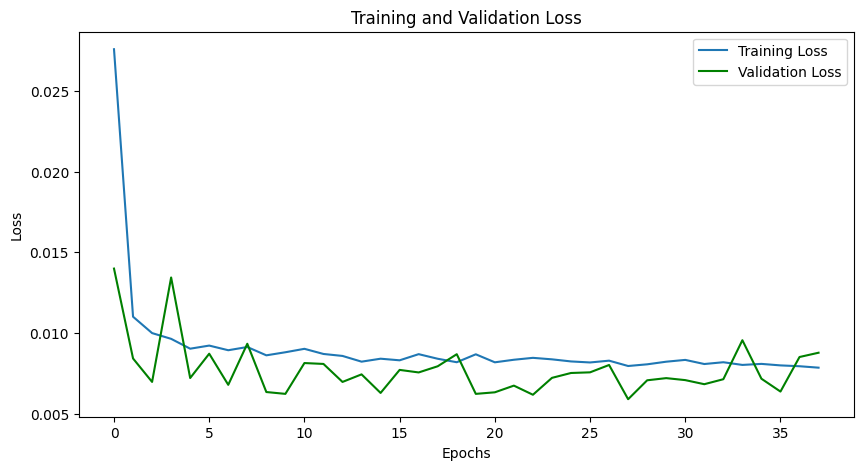

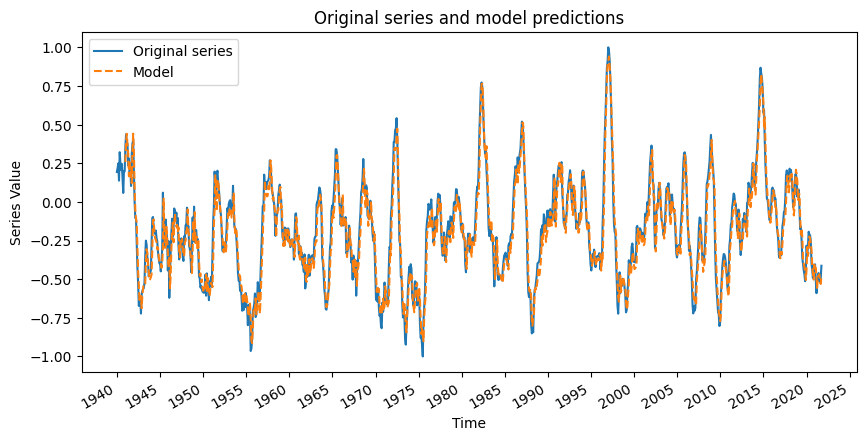

Test Loss: 0.005456435192074929
MSE: 0.005456435155806869
RMSE: 0.07386768681776132
MAE: 0.3729325408338673
Correlation: 0.9772078466245002
R^2: 0.9539316145489329


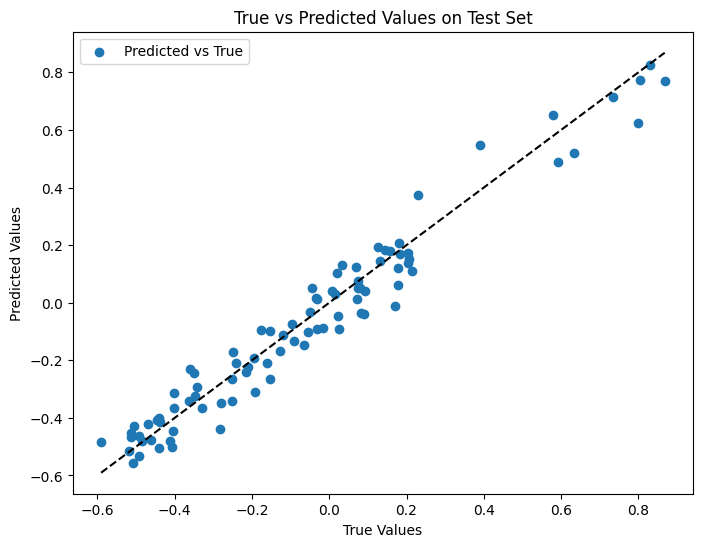

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Val Loss: 0.00616301238202355
Epoch 10 Val Loss: 0.0029500346466352573
Early stopping at epoch 16


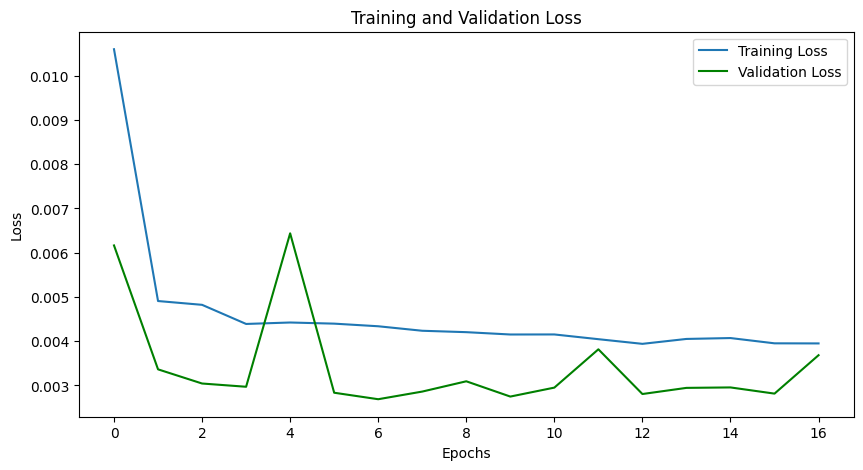

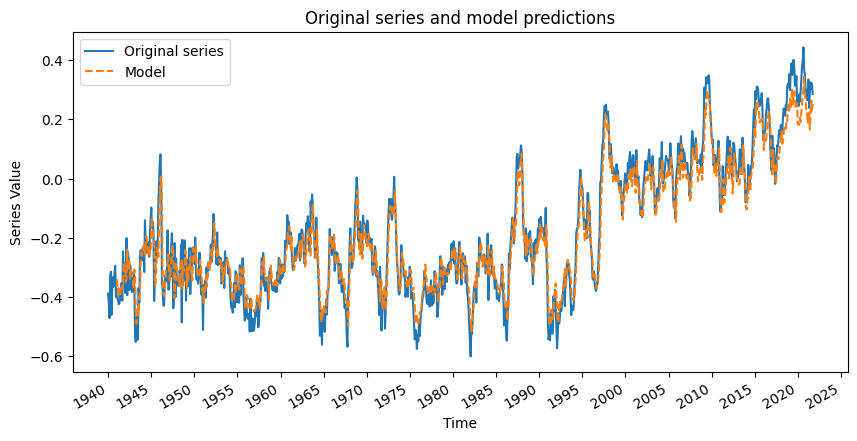

Test Loss: 0.005857290139667047
MSE: 0.005857290156888169
RMSE: 0.0765329351121997
MAE: 0.11911403268938744
Correlation: 0.8932893394117416
R^2: 0.4545456464693055


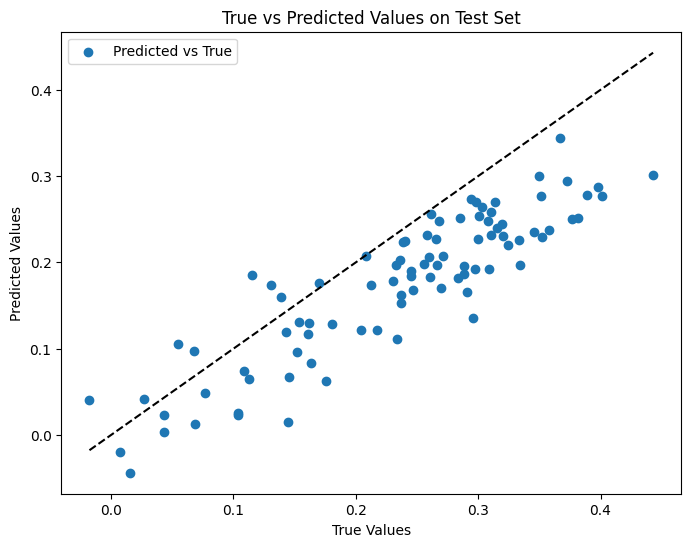

In [7]:
i_max = 2
for i in range(i_max):
  series_i = normalized_data[i]

  # Initialise data
  train_data, val_data, test_data = split_data(series_i, train_percentage, val_percentage)

  X_train, y_train = create_sequences(train_data, seq_length)
  X_val, y_val = create_sequences(val_data, seq_length)
  X_test, y_test = create_sequences(test_data, seq_length)

  X_train, y_train = to_tensor(X_train, y_train)
  X_val, y_val = to_tensor(X_val, y_val)
  X_test, y_test = to_tensor(X_test, y_test)

  train_loader = create_dataloader(X_train, y_train)
  val_loader = create_dataloader(X_val, y_val)
  test_loader = create_dataloader(X_test, y_test, shuffle=False)

  # Initialise the model
  model = MLPModel(input_size, hidden_size, output_size)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # Initialise training
  train_model(model, train_loader, val_loader, optimizer, loss_function, epochs, patience)

  # Make predictions for the whole series
  predictions = predict_whole_series(model, series_i, seq_length)

  # Generate date range for the x-axis
  start_date = datetime(1940, 1, 1)
  date_range = [start_date + timedelta(days=30 * i) for i in range(len(series_i))]

  # Plot the original series and the predicted series
  plt.figure(figsize=(10, 5))
  plt.plot(date_range, series_i, label='Original series')
  # Adding NaNs at the beginning of the predictions for alignment
  predictions = [np.nan] * seq_length + predictions
  plt.plot(date_range, predictions, label='Model', linestyle='--')
  plt.xlabel('Time')
  plt.ylabel('Series Value')
  plt.title('Original series and model predictions')
  plt.legend()

  # Format x-axis with dates every 5 years
  plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  plt.gcf().autofmt_xdate()

  plt.show()

  # Call the evaluation function
  test_loss, mse, rmse, mae, correlation, r2, predictions = evaluate_model(model, test_loader, loss_function)
  print(f"Test Loss: {test_loss}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"Correlation: {correlation}")
  print(f"R^2: {r2}")


  # Scatter plot for true vs predicted values on test set
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, predictions, label='Predicted vs True')
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.title('True vs Predicted Values on Test Set')
  plt.legend()
  plt.show()

4.4 forecast of 9 months

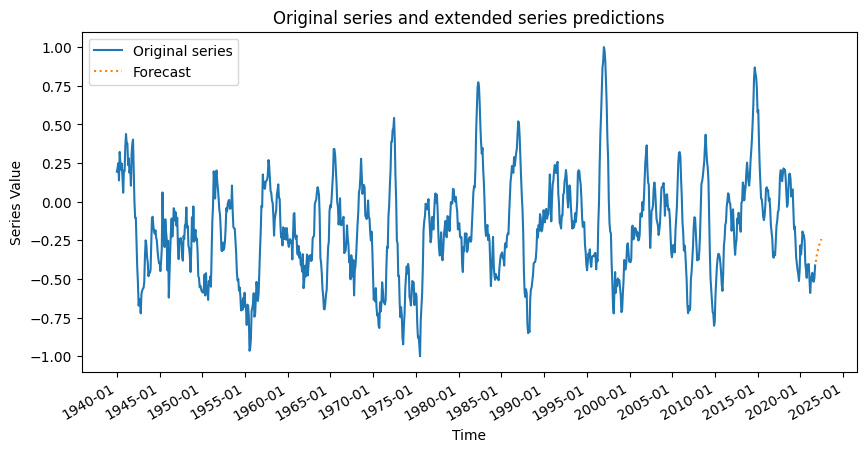

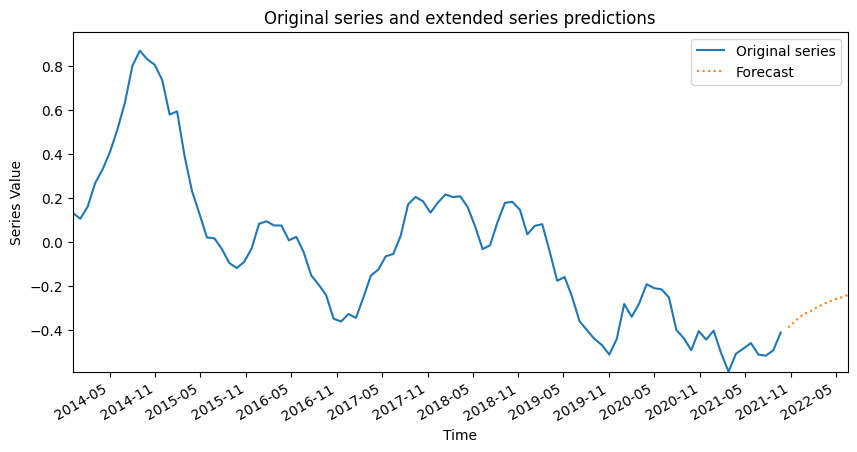

Future 9-month predictions: [-0.3896445631980896, -0.35905468463897705, -0.3295865058898926, -0.3161153197288513, -0.2954251170158386, -0.27951884269714355, -0.2651593089103699, -0.25476986169815063, -0.24222515523433685]


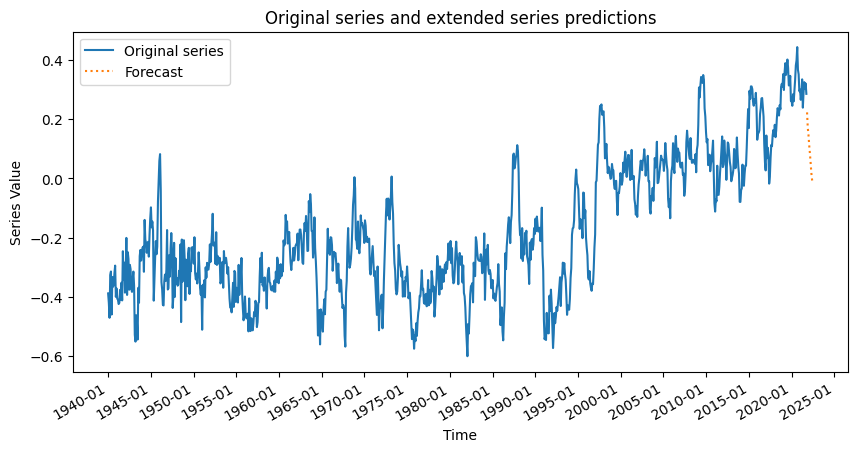

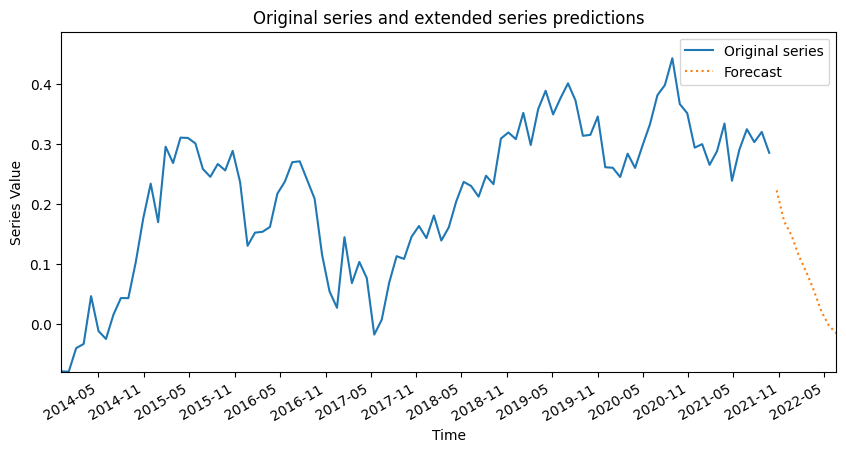

Future 9-month predictions: [0.2226877063512802, 0.17110270261764526, 0.14763659238815308, 0.1129162460565567, 0.08601406216621399, 0.05552990734577179, 0.020945213735103607, -0.0024388059973716736, -0.015430234372615814]


In [8]:
# Function to forecast future values
def extend_series(model, series, seq_length, n_months):
    model.eval()
    extended_series = list(series)  # Copy original series
    current_sequence = series[-(seq_length):]  # Start from last temporal window
    with torch.no_grad():
        for _ in range(n_months):
            seq = torch.tensor(current_sequence, dtype=torch.float32).view(-1, input_size * seq_length)
            y_pred = model(seq)
            extended_series.append(y_pred.item())  # Add prediction to final series
            current_sequence = extended_series[-seq_length:]  # Refresh moving window

    return extended_series

for i in range(2):
  series_i = series_i = normalized_data[i]

  # Compute forecast
  n_months = 9
  extended_series = extend_series(model, series_i, seq_length, n_months)

  # Generate date range for the x-axis
  start_date = datetime(1940, 1, 1)
  date_range = [start_date + timedelta(days=30 * i) for i in range(len(extended_series))]

  # Original series part
  original_series_dates = date_range[:len(series_i)]
  original_series_values = series_i

  # Forecast series part
  forecast_dates = date_range[len(series_i):]
  forecast_values = extended_series[len(series_i):]

  # Plot original series and forecast
  plt.figure(figsize=(10, 5))
  plt.plot(original_series_dates, original_series_values, label='Original series')
  plt.plot(forecast_dates, forecast_values, label='Forecast', linestyle='dotted')
  plt.xlabel('Time')
  plt.ylabel('Series Value')
  plt.title('Original series and extended series predictions')
  plt.legend()

  # Format x-axis with dates
  plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Every 5 years
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  plt.gcf().autofmt_xdate()

  plt.show()

  # Zoom in the last portion of the series
  plt.figure(figsize=(10, 5))
  plt.plot(original_series_dates, original_series_values, label='Original series')
  plt.plot(forecast_dates, forecast_values, label='Forecast', linestyle='dotted')
  plt.xlabel('Time')
  plt.ylabel('Series Value')
  plt.title('Original series and extended series predictions')
  plt.legend()
  plt.xlim(date_range[900], date_range[-1])
  plt.ylim(min(series_i[900:]), max(extended_series[900:]) * 1.1)

  # Format x-axis with detailed dates
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Every 6 months
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  plt.gcf().autofmt_xdate()

  plt.show()

  print(f"Future {n_months}-month predictions: {extended_series[len(series_i):]}")


4.5 detrended

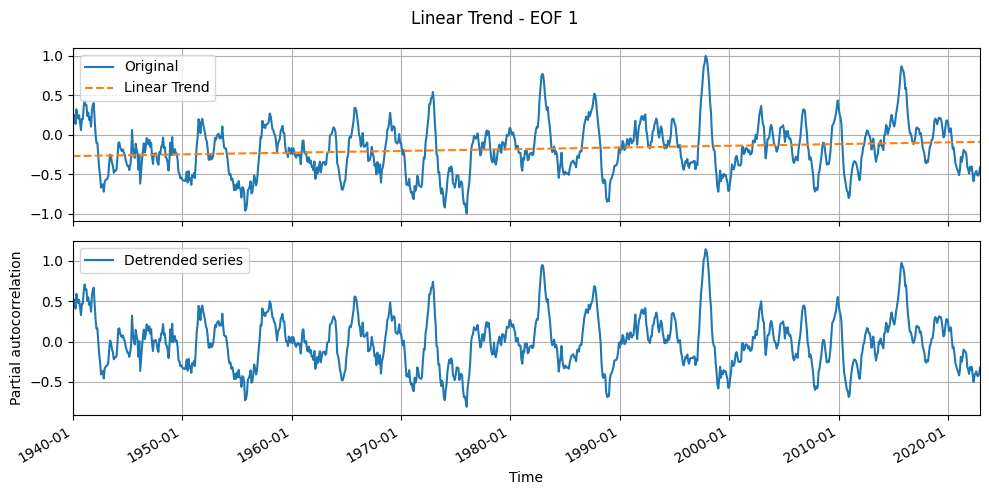

Test Statistic: -7.926265502385095
p-value: 3.611868498182969e-12
Critical Values:
	1%: -3.4369860032923145
	5%: -2.8644697838498376
	10%: -2.5683299626694422

Test result:
The series is stationary with 5% of significance level.


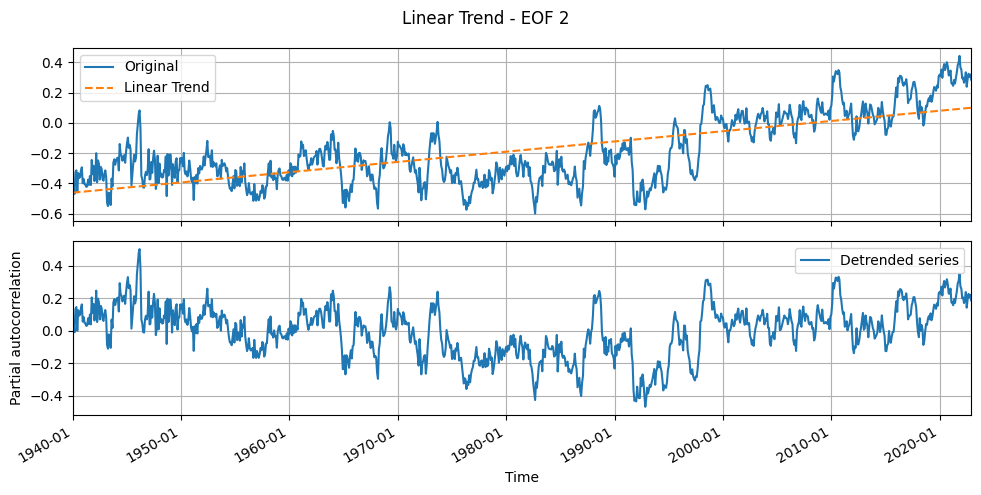

Test Statistic: -4.251791804557162
p-value: 0.0005378028883739458
Critical Values:
	1%: -3.4370266558635914
	5%: -2.864487711945291
	10%: -2.5683395116993872

Test result:
The series is stationary with 5% of significance level.


In [9]:
# DETRENDED

detrended_series_list = []
trend_list = []

for i in range(2):
    series_i = normalized_data[i]
    time_index = np.arange(len(series_i))#.reshape(-1, 1) #array con indici temporali 1-996 in collona (reshape)
    date_index = pd.date_range(start='1940-01-01', periods=996, freq='MS')

    # Compute the linear trend
    m, b = np.polyfit(time_index, series_i, 1)
    trend = m * time_index + b
    trend_list.append(trend)
    detrended_series = series_i - trend
    detrended_series_list.append(detrended_series)

    # Plot original series and trend
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    fig.suptitle('Linear Trend - EOF ' + str(i+1))
    axes[0].plot(date_index, series_i, label='Original')
    axes[0].plot(date_index, trend, label='Linear Trend', linestyle='--')
    axes[0].legend(loc='upper left')
    axes[0].grid(True)
    axes[1].plot(date_index, detrended_series, label='Detrended series')
    axes[1].legend(loc='upper left')
    axes[1].grid(True)
    axes[1].xaxis.set_major_locator(mdates.YearLocator(10, month=1, day=1)) # 10 year interval x-ticks, tick at 01/01/year
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[1].set_xlim([date_index[0], date_index[-1]])
    plt.gcf().autofmt_xdate()
    plt.xlabel('Time')
    plt.ylabel('Partial autocorrelation')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Hypothesis test
    result = adfuller(detrended_series)

    print('Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('')

    # Result interpretation
    print('Test result:')
    if result[1] < 0.05:
        print("The series is stationary with 5% of significance level.")
    else:
        print("The series is not stationary with 5% of significance level.")

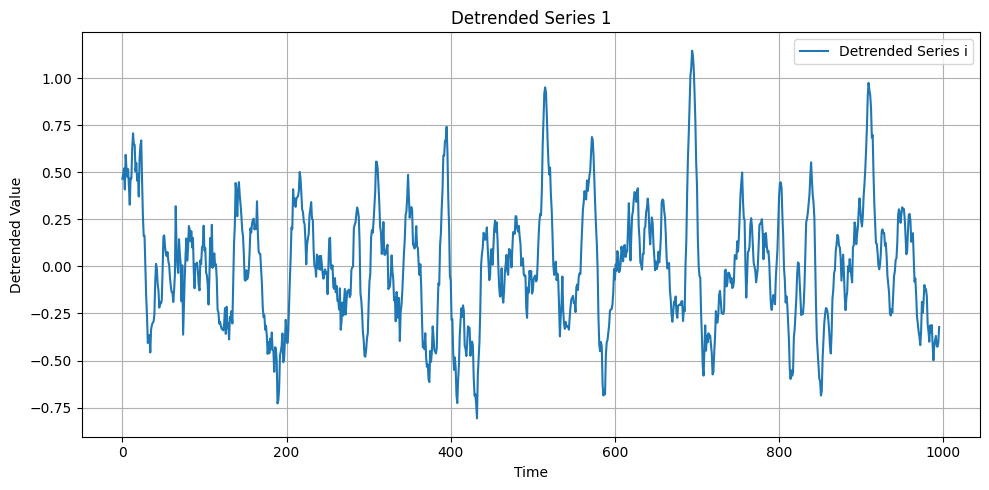

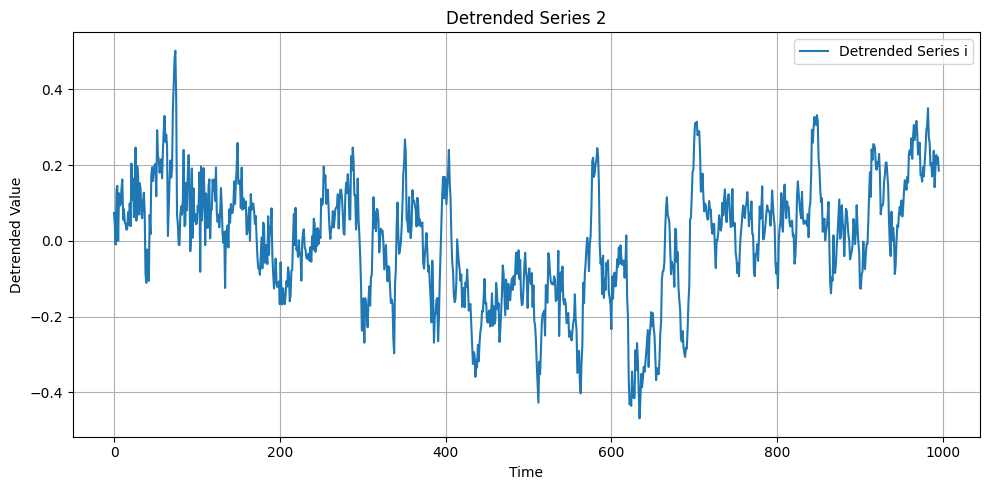

In [10]:
# Plot della serie detrended

for i in range(2):
  detrended_series_i = pd.Series(detrended_series_list[i])
  plt.figure(figsize=(10, 5))
  detrended_series_i.plot(label='Detrended Series i')
  plt.xlabel('Time')
  plt.ylabel('Detrended Value')
  plt.title('Detrended Series ' + str(i+1))
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Val Loss: 0.003705167854461577
Epoch 10 Val Loss: 0.00330795199129327
Early stopping at epoch 13


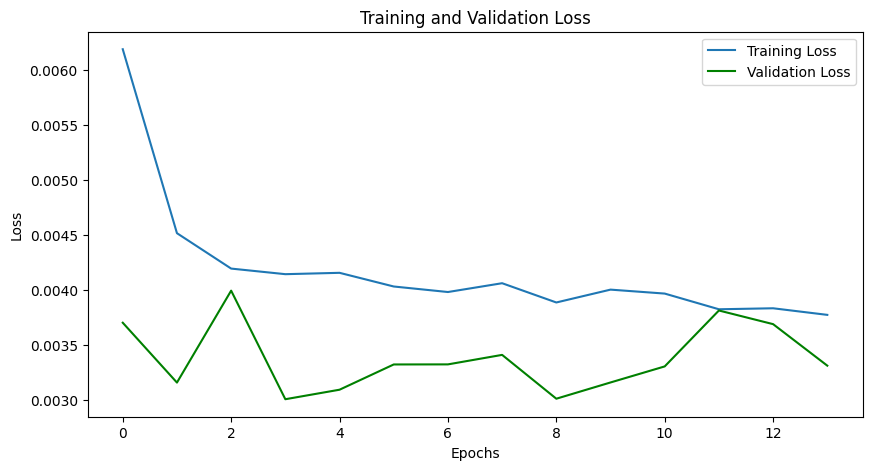

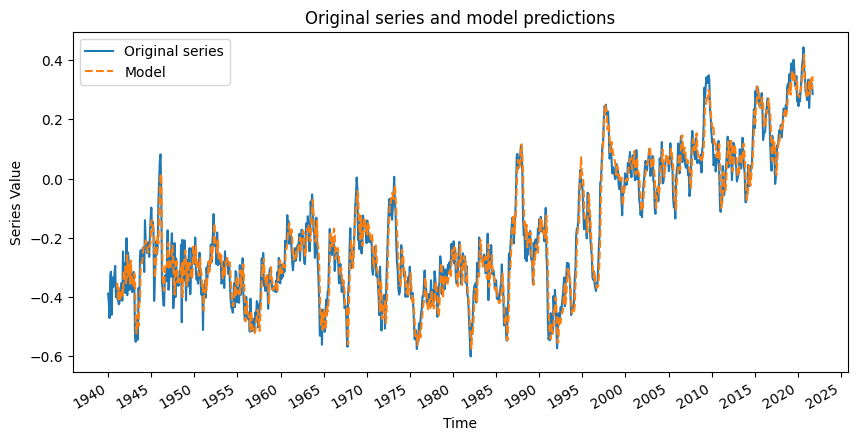

Test Loss: 0.0022062955278187883
MSE: 0.0022062955210310087
RMSE: 0.04697122013564273
MAE: 0.10420888993980465
Correlation: 0.8759686388534635
R^2: 0.7628084974765117


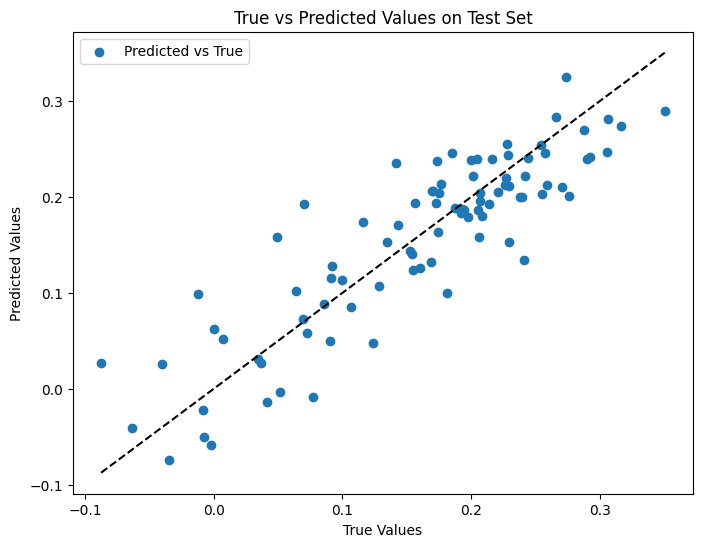

In [14]:
# Detrended series
i=1
series_i = detrended_series_list[i]

# Initialise data for detrended series
train_data, val_data, test_data = split_data(series_i, train_percentage, val_percentage)

X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train, y_train = to_tensor(X_train, y_train)
X_val, y_val = to_tensor(X_val, y_val)
X_test, y_test = to_tensor(X_test, y_test)

train_loader = create_dataloader(X_train, y_train)
val_loader = create_dataloader(X_val, y_val)
test_loader = create_dataloader(X_test, y_test, shuffle=False)

# Initialise the model
model = MLPModel(input_size, hidden_size, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialise training
train_model(model, train_loader, val_loader, optimizer, loss_function, epochs, patience)

# Make predictions for the whole series
predictions = predict_whole_series(model, series_i, seq_length)

# Generate date range for the x-axis
start_date = datetime(1940, 1, 1)
date_range = [start_date + timedelta(days=30 * i) for i in range(len(series_i))]

# Plot the original series and the predicted series
plt.figure(figsize=(10, 5))
plt.plot(date_range, normalized_data[1], label='Original series')
# Adding NaNs at the beginning of the predictions for alignment
predictions = [np.nan] * seq_length + predictions+trend_list[1]
plt.plot(date_range, predictions, label='Model', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.title('Original series and model predictions')
plt.legend()

# Format x-axis with dates every 5 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.show()

# # Function to evaluate model including R^2 and RMSE
# def evaluate_model(model, test_loader, loss_function):
#     model.eval()
#     test_losses = []
#     predictions = []
#     targets = []
#     with torch.no_grad():
#         for seq, labels in test_loader:
#             y_pred = model(seq)
#             test_loss = loss_function(y_pred, labels)
#             test_losses.append(test_loss.item())
#             predictions.extend(y_pred.tolist())
#             targets.extend(labels.tolist())
#     test_loss = np.mean(test_losses)
#     predictions = np.array(predictions)
#     targets = np.array(targets)
#     mse = mean_squared_error(targets, predictions)
#     rmse = np.sqrt(mse)
#     mae = np.mean(np.abs(predictions - targets))
#     correlation = np.corrcoef(predictions.squeeze(), targets.squeeze())[0, 1]
#     r2 = r2_score(targets, predictions)
#     return test_loss, mse, rmse, mae, correlation, r2, predictions

# Call the evaluation function
test_loss, mse, rmse, mae, correlation, r2, predictions = evaluate_model(model, test_loader, loss_function)
print(f"Test Loss: {test_loss}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Correlation: {correlation}")
print(f"R^2: {r2}")

# Scatter plot for true vs predicted values on test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, label='Predicted vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values on Test Set')
plt.legend()
plt.show()